## Layouts gallery

This example shows

- a selection of layouts easily accessible via alph
- layout seeding for repeatable rendering
- use of degree centrality for node sizing
- use of Altair for custom facet-style plots, with custom captions

It is based on the classic [Zachary's Karate Club graph](https://en.wikipedia.org/wiki/Zachary%27s_karate_club), available from NetworkX.

In [1]:
import sys

import altair as alt
import networkx as nx
import numpy as np

".." not in sys.path and sys.path.append("..")
from alph import alph, layout, util

util.set_altair_renderer()

First, generate the Karate Club graph, and set a degree centrality attribute on each node.

In [2]:
G_karate_club = nx.karate_club_graph()
nx.set_node_attributes(
    G_karate_club,
    nx.degree_centrality(G_karate_club),
    "degree_centrality"
)

Define the various layouts we'd like to render, and seed them for consistent representation.

In [3]:
SEED = 123

LAYOUTS_SPEC = {
    "NetworkX spring layout": lambda g: nx.spring_layout(
        g,
        weight="weight",
        k=1,
        iterations=1000,
        seed=SEED
    ),
    "NetworkX Fruchterman Reingold layout": lambda g: nx.fruchterman_reingold_layout(
        g,
        weight="weight",
        k=0.3,
        seed=SEED
    ),
    "scikit-network Force Atlas layout": lambda g: layout.force_atlas_sknet(
        g,
        n_iter=100,
        gravity_factor=0.01,
        repulsive_factor=0.1,
        init_seed=SEED,
    ),
    "ForceAtlas2 (fa2) library layout": lambda g: layout.force_atlas(
        g,
        weight_attr="weight",
        strongGravityMode=True,
        gravity=1,
        edgeWeightInfluence=1.2,
        seed=SEED,
    ),
    "Graphviz dot layout": lambda g: nx.nx_agraph.graphviz_layout(
        g,
        prog="dot"
    ),
    "Graphviz neato layout": lambda g: nx.nx_agraph.graphviz_layout(
        g,
        prog="neato"
    ),
}

# store the captions and the layout functinos separately for convenience below
captions, layout_fns = zip(*LAYOUTS_SPEC.items())

Define the charting function; we invoke `alph` with the chosen layout and caption,
plus various node and edge attributes.

In [4]:
def chart_for_layout(layout_fn, caption):
    return alph(
        G_karate_club,
        weight_attr="weight",
        layout_fn=layout_fn,
        node_args=dict(
            size=alt.Size(
                "degree_centrality",
                scale=alt.Scale(domain=[0,1],
                range=[4**2, 16**2]),
                legend=None
            ),
            fill=alt.Color("club:N", legend=None),
            stroke="#888",
            strokeWidth=0.3,
            tooltip_attrs=["club"],
        ),
        edge_args=dict(
            color="black",
            opacity=0.3,
            strokeWidth=alt.Size(
                "weight:Q",
                scale=alt.Scale(domain=[0,1], range=[0, 0.2]),
                legend=None
            ),
        ),
        width=300,
        height=300,
        padding=16,
        prop_kwargs=dict(
            title=alt.TitleParams(
                caption,
                baseline='bottom',
                orient='bottom',
                fontWeight='normal',
                fontSize=10
            ),
        ),
    )

Finally, iterate over the layouts, and render the corresponding graphs
in a grid with the specified number of columns.

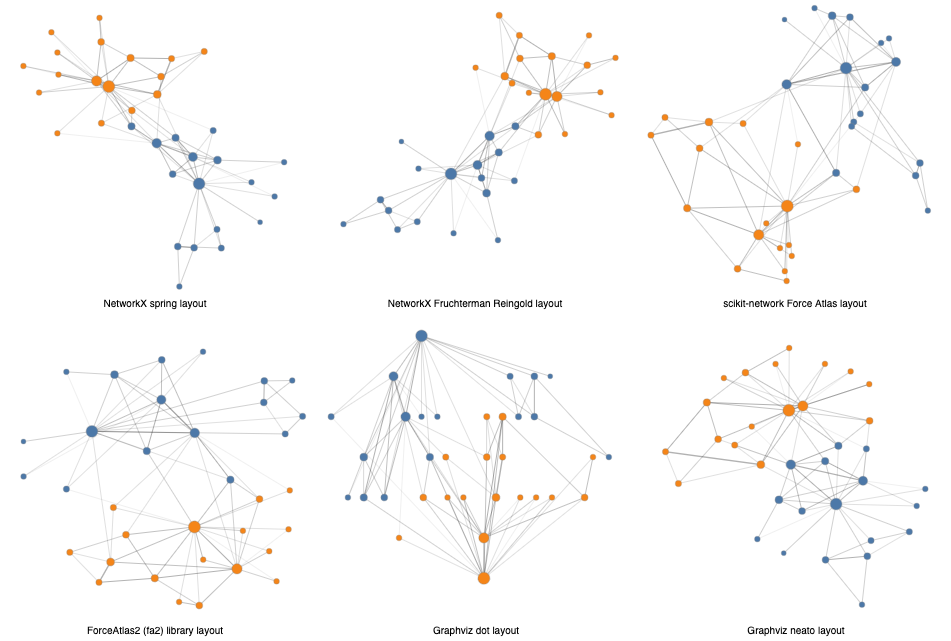

In [5]:
from functools import reduce

cols = 3
res = None

for row in range((1+len(layout_fns)) // cols):
    row_charts = [
        chart_for_layout(layout_fns[i], captions[i])
        for i in range(row * cols, min((row+1) * cols, len(layout_fns)))
    ]
    row_chart = reduce(
        lambda a, x: a | x, row_charts[1:], row_charts[0]
    )

    res = row_chart if res is None else res & row_chart

res.configure_view(strokeWidth=0)